# Absorbing channel : Large reservoir

In [1]:
from brownpy.gpu_sim import Universe
import brownpy.topology as Top
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/axes_grid1/inset_locator_demo.html
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import numpy as np
from tqdm.auto import tqdm
plt.style.use('dark_background')

In [2]:
dt = int(1E6) #fs (1ns) - time steps
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

# Geometry
L = 1E3 # A (100nm) - channel length
h = 1E2 # A (10nm)  - channel height
R = 1E4 # A (1um) - reservoir size

N= 2*1024


In [26]:
f'{D/h**2*1E15:.2e}'

'1.50e+07'

In [3]:
# top = Top.ElasticChannel1(L=L, h=h, R=R)
l= 0.8E9*1E-15*dt # 0.8GHz
top = Top.AbsorbingChannel1(L=L, h=h, R=R, l=l)
u = Universe(N=N, top=top, D=D, dt=dt,
             output_path='simu')
             

simu.hdf5 already exists, change output filename for simu_3.hdf5


In [5]:
u.run(1_000_000, freq_dumps=100);
u.run(10_000_000);

  0%|          | 0/10000000 [00:00<?, ?it/s]

With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 3.2 fs
Engine: 130 ps
Transfert to RAM: 12.8 ps
Total: 143 ps
------------------------------------------
CPU time per step and per particles:
Other: 289 ps
Transfert to drive: 9.43 ps
Total: 299 ps
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 299 ms


100%|██████████| 10000000/10000000 [00:25<00:00, 388471.03it/s, total=11 ms]

With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 255 as
Engine: 12.3 ps
Transfert to RAM: 108 fs
Total: 12.4 ps
------------------------------------------
CPU time per step and per particles:
Other: 102 fs
Transfert to drive: 12.3 ps
Total: 12.4 ps
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 12.4 ms


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>)

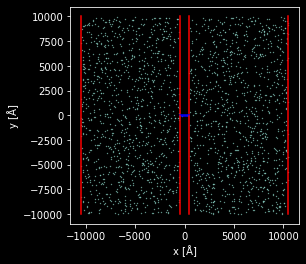

In [6]:
u.plot_pos()

Reading region_0 ...
... Done
Reading trajectory ...
... Done


(-1000.0, 1000.0)

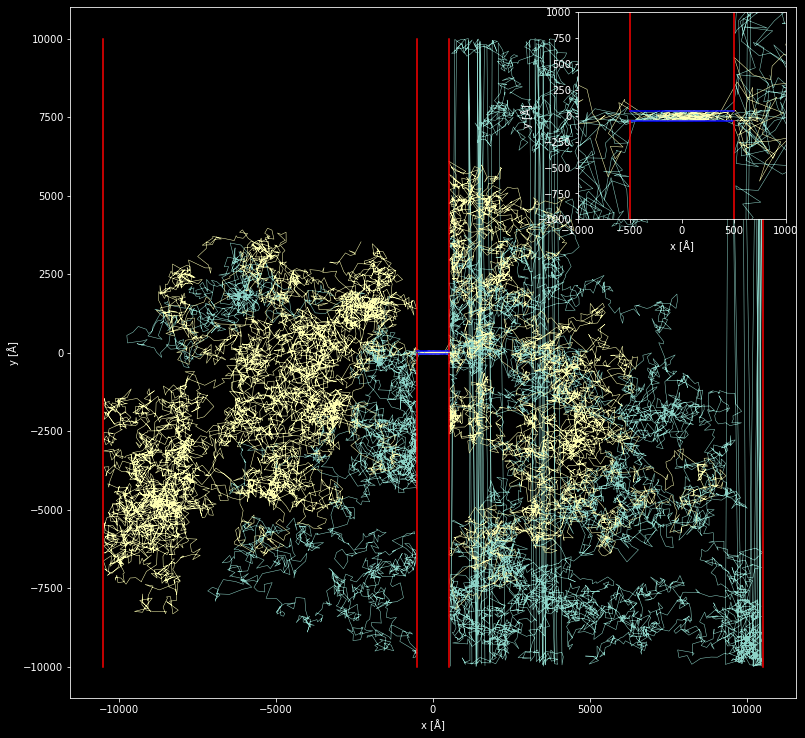

In [7]:
data=u[0]
trajectory = data['trajectory']
# Get particles that go inside the channel
# i_particle=1107
fig, ax1 = plt.subplots(figsize=(13,13))
ax1_in = inset_axes(ax1, width="30%", height="30%", loc=1)

# ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])
temp = np.argsort(np.sum(np.abs(trajectory[:,0,:-2])<L/2, axis=1))[::-1]
i_particle = temp[0]
for ax in [ax1, ax1_in]:
        
        # ax.scatter(trajectory[i_particle,0,:], trajectory[i_particle,1,:], 
        #    c=np.arange(trajectory.shape[2]), marker='.', cmap='jet', s=0.1)
        for i_particle in temp[:2]:
                ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:], lw=0.5)

        # for i_particle in range(trajectory.shape[0]):
        #         ax.plot(trajectory[i_particle,0,:2], trajectory[i_particle,1,:2])

        top.plot(ax)

ax1_in.set_xlim(-1000,1000)
ax1_in.set_ylim(-1000,1000)


Reading region_0 ...
... Done


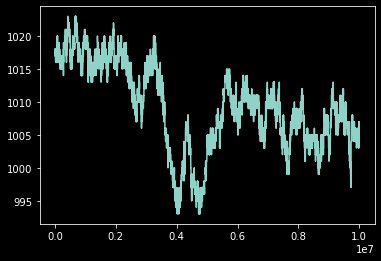

In [8]:
data=u[1]
region_0=data['region_0']
plt.plot(region_0)

In [9]:
import cupy as cp
def PSD_gpu(x, dt):
    x_gpu = cp.asarray(x)
    psd = (cp.abs(cp.fft.rfft(x_gpu))**2).get()
    freqs = (cp.fft.rfftfreq(x.size, dt)).get()
    del x_gpu
    cp._default_memory_pool.free_all_blocks()
    return psd, freqs

def PSD_gpu_binned(x, dt, bins):
    x_gpu = cp.asarray(x)
    psd_gpu = cp.abs(cp.fft.rfft(x_gpu))**2
    freqs_gpu = cp.fft.rfftfreq(x.size, dt)

    psd_binned_gpu, freqs_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], 
                                        weights=psd_gpu[1:], bins=bins)
    N_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], bins=bins)[0]
    psd_averaged = (psd_binned_gpu/N_binned_gpu).get()
    freqs = ((freqs_binned_gpu[1:]+freqs_binned_gpu[:-1])/2.).get()
    
    del x_gpu, psd_gpu, freqs_gpu, psd_binned_gpu, freqs_binned_gpu, N_binned_gpu
    cp._default_memory_pool.free_all_blocks()
    return psd_averaged, np.exp(freqs)

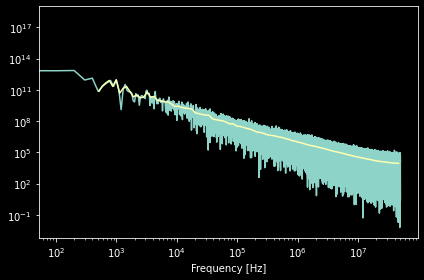

In [10]:
fig, ax = plt.subplots()
psd, freqs = PSD_gpu(region_0[::10], dt*10)
ax.loglog(freqs*1E15, psd)
psd_bin, freqs_bin = PSD_gpu_binned(region_0[::10], dt*10, bins=100)
ax.loglog(freqs_bin*1E15, psd_bin)
ax.set_xlabel('Frequency [Hz]')
fig.tight_layout()

In [11]:
# top = Top.ElasticChannel1(L=L, h=h, R=R)
l= 0.8E6*1E-15*dt # 0.8GHz
top = Top.AbsorbingChannel1(L=L, h=h, R=R, l=l)
u = Universe(N=N, top=top, D=D, dt=dt,
             output_path='simu')

simu.hdf5 already exists, change output filename for simu_4.hdf5


In [12]:
u.run(1_000_000, freq_dumps=100);
u.run(10_000_000);

  0%|          | 0/10000000 [00:00<?, ?it/s]

With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 2.6 fs
Engine: 127 ps
Transfert to RAM: 9.51 ps
Total: 136 ps
------------------------------------------
CPU time per step and per particles:
Other: 262 ps
Transfert to drive: 6.3 ps
Total: 269 ps
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 269 ms


100%|██████████| 10000000/10000000 [00:25<00:00, 393208.41it/s, total=11 ms]

With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 257 as
Engine: 12 ps
Transfert to RAM: 101 fs
Total: 12.2 ps
------------------------------------------
CPU time per step and per particles:
Other: 158 fs
Transfert to drive: 12.1 ps
Total: 12.3 ps
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 12.3 ms


Reading region_0 ...
... Done
Reading trajectory ...
... Done


(-1000.0, 1000.0)

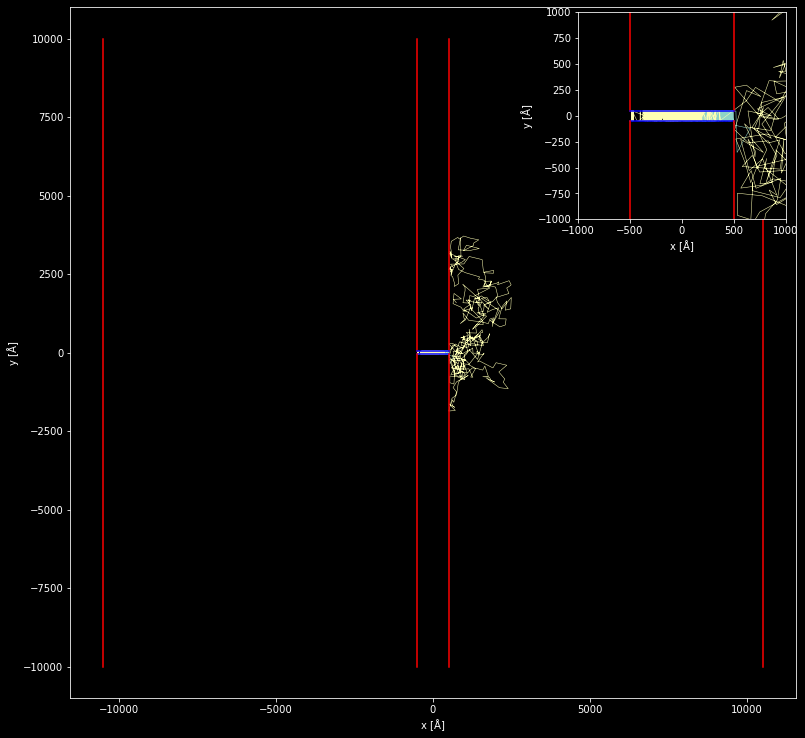

In [13]:
data=u[0]
trajectory = data['trajectory']
# Get particles that go inside the channel
# i_particle=1107
fig, ax1 = plt.subplots(figsize=(13,13))
ax1_in = inset_axes(ax1, width="30%", height="30%", loc=1)

# ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])
temp = np.argsort(np.sum(np.abs(trajectory[:,0,:-2])<L/2, axis=1))[::-1]
i_particle = temp[0]
for ax in [ax1, ax1_in]:
        
        # ax.scatter(trajectory[i_particle,0,:], trajectory[i_particle,1,:], 
        #    c=np.arange(trajectory.shape[2]), marker='.', cmap='jet', s=0.1)
        for i_particle in temp[:2]:
                ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:], lw=0.5)

        # for i_particle in range(trajectory.shape[0]):
        #         ax.plot(trajectory[i_particle,0,:2], trajectory[i_particle,1,:2])

        top.plot(ax)

ax1_in.set_xlim(-1000,1000)
ax1_in.set_ylim(-1000,1000)


Reading region_0 ...
... Done


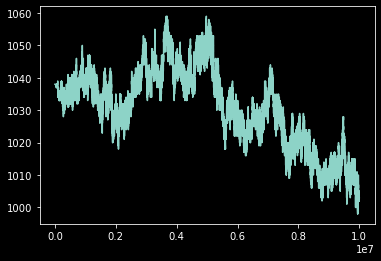

In [14]:
data=u[1]
region_0=data['region_0']
plt.plot(region_0)

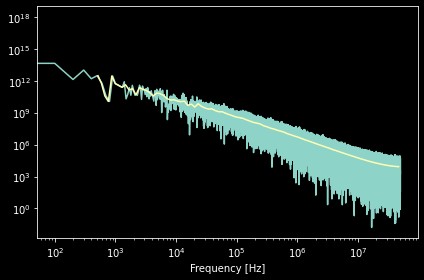

In [15]:
fig, ax = plt.subplots()
psd_elastic, freqs_elastic = PSD_gpu(region_0[::10], dt*10)
ax.loglog(freqs_elastic*1E15, psd_elastic)
psd_bin_elastic, freqs_bin_elastic = PSD_gpu_binned(region_0[::10], dt*10, bins=100)
ax.loglog(freqs_bin_elastic*1E15, psd_bin_elastic)
ax.set_xlabel('Frequency [Hz]')
fig.tight_layout()

In [16]:
from scipy import signal

In [17]:
freqs_welch_elastic, psd_welch_elastic = signal.welch(region_0[::10], 0.1/dt , nperseg=64*1024)

In [18]:
1E15/(dt*len(region_0))

100.0

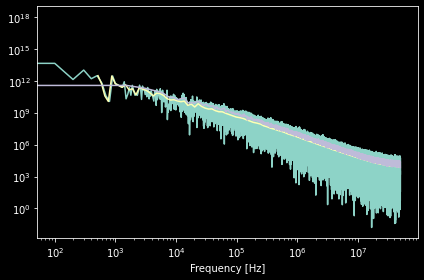

In [19]:
fig, ax = plt.subplots()
ax.loglog(freqs_elastic*1E15, psd_elastic)
ax.loglog(freqs_bin_elastic*1E15, psd_bin_elastic)
ax.loglog(freqs_welch_elastic*1E15, psd_welch_elastic/10)
# ax.psd(region_0, 512, 1 / dt)
ax.set_xlabel('Frequency [Hz]')
fig.tight_layout()

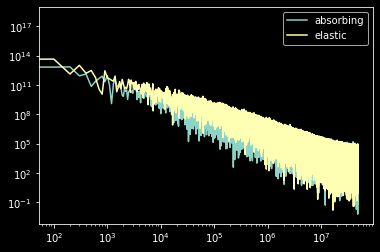

In [22]:
fig, ax = plt.subplots()
ax.loglog(freqs*1E15, psd, label='absorbing')
ax.loglog(freqs_elastic*1E15, psd_elastic, label='elastic')
ax.legend()

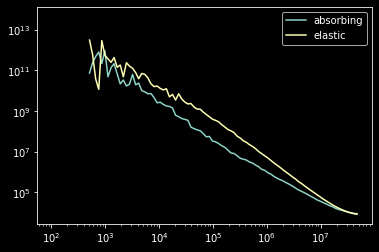

In [21]:
fig, ax = plt.subplots()
ax.loglog(freqs_bin*1E15, psd_bin, label='absorbing')
ax.loglog(freqs_bin_elastic*1E15, psd_bin_elastic, label='elastic')
ax.legend()

In [9]:
-108%200-100

-8

In [23]:
a = 150
a = (100+a)%200-100
a

-50

In [17]:

from abc import ABC, abstractmethod
 
class AbstractClassExample(ABC):
    
    @abstractmethod
    def _do_something(self):
        print("Some implementation!")
        
class AnotherSubclass(AbstractClassExample):

    def _do_something(self):
        super()._do_something()
        print("The enrichment from AnotherSubclass")
        
x = AnotherSubclass()
x._do_something()

-98

In [ ]:
from numba import jit
exec(
'''
@jit('float64[:](float64[:], float64[:])', nopython=True)
def test_kernel(a, b):
    return a + b
''')
N=1000
array_a = np.random.uniform(size=N)
array_b = np.random.uniform(size=N)
array_out = np.zeros_like(array_a)
array_out = test_kernel(array_a, array_b)

from numba import cuda
@cuda.jit(device=True)
def test_device(a,b):
    return a+b
@cuda.jit
def test_kernel(array_a, array_b, array_out):
    pos = cuda.grid(1)
    if pos < array_a.size:
        array_out[pos] = test_device(array_a[pos], array_b[pos])

N=1000
array_a = np.random.uniform(size=N)
array_b = np.random.uniform(size=N)
array_out = np.zeros_like(array_a)

threadsperblock = 32
blockspergrid = int(np.ceil(N/threadsperblock))
test_kernel[blockspergrid, threadsperblock](array_a, array_b, array_out)


In [1]:
# https://numba.pydata.org/numba-doc/dev/cuda/simulator.html
import os 
os.environ["NUMBA_ENABLE_CUDASIM"] = "0"

from brownpy.gpu_sim import Universe
import brownpy.topology as Top

seed = 0

dt = int(1E6) #fs (1ns) - time steps
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

# Geometry
L = 1E3 # A (100nm) - channel length
h = 1E2 # A (10nm)  - channel height
R = 1E4 # A (1um) - reservoir size

N= 2*1024

top = Top.ElasticChannel1(L=L, h=h, R=R)
u = Universe(N=N, top=top, D=D, dt=dt,
             output_path='simu', seed=seed)

u.run(100, freq_dumps=1, seed=seed);

simu.hdf5 already exists, change output filename for simu_15.hdf5


100%|██████████| 100/100 [00:03<00:00, 29.59it/s, total=100 ns]

With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 16.4 µs
Engine: 30.7 ns
Transfert to RAM: 79.9 ns
Total: 16.5 µs
------------------------------------------
CPU time per step and per particles:
Other: 16.5 µs
Transfert to drive: 13.9 ns
Total: 16.5 µs
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 16.5 ks


In [2]:
data = u[0]

Reading region_0 ...
... Done
Reading trajectory ...
... Done


(-100.0, 180.0)

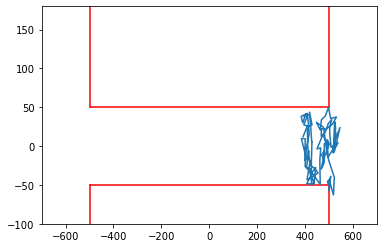

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
border_kwargs = {'c': 'r'}

ax.plot([-L/2-R, -L/2-R], [-R, +R], **border_kwargs)
ax.plot([ L/2+R,  L/2+R], [-R, +R], **border_kwargs)

ax.plot([-L/2, -L/2], [R, h/2], **border_kwargs)
ax.plot([+L/2, +L/2], [R, h/2], **border_kwargs)
ax.plot([-L/2, +L/2], [h/2, h/2], **border_kwargs)
ax.plot([-L/2, +L/2], [-h/2, -h/2], **border_kwargs)
ax.plot([-L/2, -L/2], [-R, -h/2], **border_kwargs)
ax.plot([+L/2, +L/2], [-R, -h/2], **border_kwargs)
# for i in range(data['trajectory'].shape[0]):
#     ax.plot(*data['trajectory'][i])
ax.plot(*data['trajectory'][2046])
ax.set_xlim(-700, 700)
ax.set_ylim(-100, 180)

In [17]:
data['trajectory'][1442]

array([[-495.57504, -506.53403, -507.26666, -505.71115, -507.83136,
        -497.0445 , -511.38406, -471.88544, -473.65988, -490.21725,
        -482.5923 , -488.3597 , -474.65518, -444.2078 , -421.7852 ,
        -408.52725, -422.4537 , -412.30225, -413.8846 , -401.93985,
        -434.11694, -450.0416 , -434.52765, -468.99802, -500.51917,
        -483.61084, -492.36047, -481.7733 , -485.92645, -468.77808,
        -478.47485, -462.92932, -482.65173, -458.4131 , -458.08005,
        -438.8931 , -433.4192 , -408.92038, -400.11584, -377.96774,
        -413.17123, -386.0985 , -341.34268, -351.40735, -358.66287,
        -342.3016 , -345.27222, -349.03714, -330.89816, -331.00272,
        -344.9954 , -342.1444 , -344.62717, -339.5413 , -340.69162,
        -300.98264, -301.47824, -285.11313, -306.75986, -294.63583,
        -303.32892, -324.75424, -297.68118, -265.80188, -270.1159 ,
        -266.5348 , -277.48843, -280.37708, -290.9354 , -308.3009 ,
        -306.70743, -321.36853, -314.2145 , -266

In [21]:
np.uint32(-1.0)

4294967295

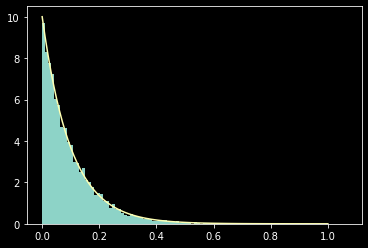

In [19]:
l=10

plt.hist(-(1/l)*np.log(np.random.uniform(size=10000)), bins=100, density=True);
x=np.linspace(0,1,100)
plt.plot(x,l*np.exp(-l*x))

In [14]:
from numba import cuda
@cuda.jit(device=True)
def test_device(a,b, array_a, internal_state):
    # internal_state[0]+=5
    pos = cuda.grid(1)
    array_a[pos]+=1
    # internal_state=(a,1)
    return a+b
@cuda.jit
def test_kernel(array_a, array_b, array_out):
    pos = cuda.grid(1)
    if pos < array_a.size:
        internal_state = cuda.local.array(1, int)
        array_out[pos] = test_device(array_a[pos], array_b[pos], array_a, internal_state)
        array_out[pos] = test_device(array_a[pos], array_b[pos], array_a, internal_state)

N=1000
array_a = np.random.uniform(size=N)
array_b = np.random.uniform(size=N)
array_out = np.zeros_like(array_a)

threadsperblock = 32
blockspergrid = int(np.ceil(N/threadsperblock))
test_kernel[blockspergrid, threadsperblock](array_a, array_b, array_out)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function local.array at 0x0000023ADCDCDD30>) found for signature:
 
 >>> array(Literal[int](1), Function(<class 'int'>))
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Overload of function 'array': File: numba\cuda\cudadecl.py: Line 44.
    With argument(s): '(int64, Function(<class 'int'>))':[0m
[1m   No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<function local.array at 0x0000023ADCDCDD30>)[0m
[0m[1mDuring: typing of call at <ipython-input-14-709766498c20> (13)
[0m
[1m
File "<ipython-input-14-709766498c20>", line 13:[0m
[1mdef test_kernel(array_a, array_b, array_out):
    <source elided>
    if pos < array_a.size:
[1m        internal_state = cuda.local.array(1, int)
[0m        [1m^[0m[0m


In [13]:
array_out

array([2.3498525 , 2.27930976, 2.42688121, 2.20877269, 1.93448136,
       1.9000963 , 1.91918237, 1.81798059, 1.81362504, 2.27645154,
       2.01472438, 2.05785706, 1.43354295, 2.05932514, 2.27046002,
       1.1584237 , 2.22701275, 1.70300182, 1.81127062, 1.71941567,
       1.37920818, 1.74754108, 2.06251021, 2.08584213, 2.1841312 ,
       2.47910827, 2.59935708, 1.37040092, 2.53835654, 2.63046278,
       2.147752  , 1.95703156, 2.83180173, 2.20412958, 1.62883226,
       1.68569702, 2.73963678, 2.24997619, 2.24876894, 1.65422584,
       2.26762478, 2.1667412 , 1.67158869, 2.60230184, 2.07755997,
       1.9262868 , 1.80706135, 2.26944221, 2.53388927, 1.97605471,
       2.2300159 , 1.89903555, 2.59642863, 2.28429412, 1.80710875,
       2.62223858, 2.85795832, 2.17872576, 1.6126543 , 2.01118482,
       1.7288964 , 2.03176383, 2.4564034 , 2.32588201, 2.68024015,
       2.33798721, 1.1738535 , 1.54502453, 1.88939114, 2.23345129,
       1.97773897, 2.368975  , 1.53212193, 1.68576272, 2.17481